# p3 Adaboost

In [1251]:
import numpy as np
from matplotlib import pyplot as plt

In [1252]:
def convert_to_one_hot(y, num_classes):
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[np.arange(y.shape[0]), y] = 1
    return y_one_hot

In [1253]:
def preprocess_data(X):
    y = X[:, 0].astype(int)
    x = np.delete(X, 0, axis = 1)
    return x, y

In [1255]:
def Match_List(y_true, y_pred):
    matches = [1 if x == y else -1 for x, y in zip(y_true, y_pred)]
    matches = np.array(matches)
    matches = matches.reshape(matches.shape)
    return matches

In [1256]:
# Splits the data with given percentages

def DataSplit(Data, train_percent, test_percent, val_percent = 0):
    split_list = []
    train_size = int(train_percent * Data.shape[0] / 100)
    val_size = int(val_percent * Data.shape[0] / 100)
    test_size = Data.shape[0] - train_size - val_size
    
    # Train and Test data
    DTrain = np.zeros((train_size, Data.shape[1]))
    DTest = np.zeros((test_size, Data.shape[1]))
    DTrain = Data[0:train_size, :]
    DTest = Data[train_size + val_size: Data.shape[0], :]
    split_list.extend([DTrain, DTest])
    
    # For validataion data
    if val_percent > 0:
        DVal = np.zeros((val_size, Data.shape[1]))
        DVal = Data[train_size: train_size + val_size, :]
        split_list.append(DVal)
    return split_list

In [1257]:
def SampleData(X, weights):
    
    indices = np.random.choice(len(X), size = len(X), replace = True, p = weights)
    Sampled_Data = X[indices]
    return Sampled_Data

## Ensemble of Decision Trees

In [1258]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [1259]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, maximum_depth=2,impurity="gini"):
        self.root = None
        self.min_samples_split=min_samples_split
        self.maximum_depth=maximum_depth
        self.impurity=impurity
        
    def Build_Tree(self,X_train,Y_train,current_depth=0):
        X_train=np.array(X_train)
        N_samples = X_train.shape[0]
        N_features=X_train.shape[1]
        
        if current_depth<=self.maximum_depth and N_samples>=self.min_samples_split:
            
            best_split = self.get_best_split(X_train,Y_train,N_samples, N_features)
            
            if(best_split["Information_gain"]>0):
                
                left_sub_tree=self.Build_Tree(best_split["left_train_X"],best_split["left_train_Y"],current_depth+1)
                
                right_sub_tree=self.Build_Tree(best_split["right_train_X"],best_split["right_train_Y"],current_depth+1)
                
                return Node(best_split["feature_index"],best_split["threshold"],left_sub_tree,right_sub_tree,best_split["Information_gain"])
        
    
            
        leaf_value=max(Y_train,key=Y_train.count)

        return Node(value=leaf_value)
        
    
    def get_best_split(self,X_train,Y_train,N_samples,N_features):
        
        best_split={}
        max_info_gain=-np.inf
        
        for feature in range(N_features):
            feature_values=X_train[:,feature]
            possible_thresholds=np.unique(feature_values)
            min_feature_value,max_feature_value=min(possible_thresholds),max(possible_thresholds)
            sample_size=min(len(possible_thresholds),20)
            #print(sample_size)
            sampled_possible_thresholds=np.random.uniform(min_feature_value,max_feature_value,size=sample_size)
            
            for threshold in sampled_possible_thresholds:
                
                left_train_X,right_train_X,left_train_Y,right_train_Y=self.split_into_left_right(X_train,Y_train,threshold,feature)
                
                if len(right_train_X)>0 and len(left_train_X)>0:
                    
                    curr_info_gain = self.information_gain(Y_train,left_train_Y, right_train_Y,self.impurity)
                    
                    if curr_info_gain>max_info_gain:
                        
                        best_split["feature_index"]=feature
                        best_split["threshold"]=threshold
                        best_split["left_train_X"]=left_train_X
                        best_split["left_train_Y"]=left_train_Y
                        best_split["right_train_X"]=right_train_X
                        best_split["right_train_Y"]=right_train_Y
                        best_split["Information_gain"]=curr_info_gain
                        max_info_gain=curr_info_gain
        
        return best_split
    
    def split_into_left_right(self,X_train,Y_train,threshold,feature):
        left_train_X=[]
        right_train_X=[]
        left_train_Y=[]
        right_train_Y=[]
        
        for i in range(len(X_train)):
            if(X_train[i][feature]<=threshold):
                left_train_X.append(X_train[i])
                left_train_Y.append(Y_train[i])
            else:
                right_train_X.append(X_train[i])
                right_train_Y.append(Y_train[i])
                
        return left_train_X,right_train_X,left_train_Y,right_train_Y
    
    def get_entropy(self,Y):
        classes=np.unique(Y)
        Y=np.array(Y)
        entropy=0
        for i in classes:
            p_i = len(Y[Y == i]) / len(Y)
            entropy+=-p_i*np.log2(p_i)
        return entropy
    
    def gini_impurity(self,Y):
        classes=np.unique(Y)
        Y=np.array(Y)
        gini=0
        for i in classes:
            p_i = len(Y[Y == i]) / len(Y)
            gini+=p_i*p_i
        return 1-gini
                
    def information_gain(self,Y_train,left_train_Y,right_train_Y,impurity):
        
        weight_left=len(left_train_Y)/len(Y_train)
        
        weight_right=len(right_train_Y)/len(Y_train)
        
        if(impurity=="entropy"):
            
            info_gain=self.get_entropy(Y_train)-(weight_left*self.get_entropy(left_train_Y)+weight_right*self.get_entropy(right_train_Y))
            
        if(impurity=="gini"):
            
            info_gain=self.gini_impurity(Y_train)-(weight_left*self.gini_impurity(left_train_Y)+weight_right*self.gini_impurity(right_train_Y))
        
            
        return info_gain
                
    
    def fit(self,X_train,Y_train):
        
        self.root=self.Build_Tree(X_train,Y_train)
        
    def predict(self,X_test):
        
        y_pred=[]
        
        for each in X_test:
            y_pred.append(self.make_predictions(each,self.root))
            
        return np.array(y_pred)
    
    def make_predictions(self,x,tree):
        
        if tree.value!=None:
            return int(tree.value)
        
        if(x[tree.feature_index]>tree.threshold):
            return self.make_predictions(x,tree.right)
        else:
            return self.make_predictions(x,tree.left)
            
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)   

In [1260]:
class AdaboostDecisionTree:
    
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []
        self.loss_list = []
        self.classes = None
        self.acc_list = []
        
    def train(self, X, max_depth = 4, impurity = "gini"):
        n_samples, _ = X.shape
        y_train = X[:, 0].astype(int)
        X_train = np.delete(X, 0, axis = 1)
        self.classes = np.unique(y_train)
        weights = np.ones(n_samples) / n_samples
        for i in range(self.n_estimators):
            estimator = DecisionTreeClassifier(min_samples_split=2, maximum_depth = max_depth, impurity = impurity)
            Sampled_X = SampleData(X, weights)
            Sampled_ytrain = Sampled_X[:, 0].astype(int)
            Sampled_Xtrain = np.delete(Sampled_X, 0, axis = 1)
            estimator.fit(Sampled_Xtrain, Sampled_ytrain)
            y_pred = estimator.predict(X_train)

            err = np.sum(weights * (y_pred != y_train))

            alpha = np.log((1-err)/err) + np.log(len(self.classes) - 1)
            weights *= np.exp(alpha * (y_pred != y_train))
            weights /= np.sum(weights)
            self.estimators.append(estimator)
            self.estimator_weights.append(alpha)
            print('No. of learners =', len(self.estimators))
            print('Accuracy of current Classifier on Train Data =', self.accuracy(y_pred, y_train))
            print('alpha =', alpha)
            y_pred_tillnow, acc = self.test(X)
            print('Accuracy of Ensemble on Train Data =', acc )
            self.update_loss(y_train, y_pred_tillnow)
            self.update_acc(acc)
            print('\n')
            
    def test(self, X):
        y_test = X[:, 0].astype(int)
        X_test = np.delete(X, 0, axis = 1)
        y_allclasses = []
        for i in range(len(self.classes)):
            y_pred_current = np.zeros(len(X))
            for estimator, alpha in zip(self.estimators, self.estimator_weights):
                current_predictions = estimator.predict(X_test)
                indicators = [1 if x == self.cla26sses[i] else 0 for x in current_predictions]
                y_pred_current += alpha * np.array(indicators).reshape(current_predictions.shape)
            y_allclasses.append(y_pred_current)
        y_allclasses = np.array(y_allclasses)
#         print(y_allclasses)
        y_pred = np.argmax(y_allclasses, axis = 0)
#         print(y_pred)
        acc = self.accuracy(y_test, y_pred)
        return y_pred, acc

    def update_loss(self, y_true, y_pred):
        matches = Match_List(y_true, y_pred)
        loss = np.mean(np.exp(-matches))
        print('Train Loss of Ensemble =', loss)
        self.loss_list.append(loss)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred) * 100
    
    def update_acc(self, acc):
        self.acc_list.append(acc)
    

### *PCA_MNIST Data*

In [1261]:
with open('./Data/PCA_MNIST.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1262]:
Data = np.array(results)

In [1263]:
print(Data.shape)

(60000, 11)


In [1264]:
Data_Train, Data_Test = DataSplit(Data, 80, 20, val_percent = 0)

In [1265]:
print(Data_Train.shape)
print(Data_Test.shape)

(48000, 11)
(12000, 11)


In [1266]:
adaboost_tree = AdaboostDecisionTree(10)

In [1267]:
adaboost_tree.train(Data_Train)

No. of learners = 1
Accuracy of current Classifier on Train Data = 73.23333333333333
alpha = 3.203717935774068
Accuracy of Ensemble on Train Data = 73.23333333333333
Train Loss of Ensemble = 0.9970038135020911


No. of learners = 2
Accuracy of current Classifier on Train Data = 49.735416666666666
alpha = 2.6916372664970454
Accuracy of Ensemble on Train Data = 73.23333333333333
Train Loss of Ensemble = 0.9970038135020911


No. of learners = 3
Accuracy of current Classifier on Train Data = 64.99583333333334
alpha = 2.488853729370665
Accuracy of Ensemble on Train Data = 79.37291666666667
Train Loss of Ensemble = 0.8526989002659124


No. of learners = 4
Accuracy of current Classifier on Train Data = 42.7375
alpha = 2.103961045370562
Accuracy of Ensemble on Train Data = 82.39583333333333
Train Loss of Ensemble = 0.7816481947668641


No. of learners = 5
Accuracy of current Classifier on Train Data = 43.5625
alpha = 1.7640225979817523
Accuracy of Ensemble on Train Data = 82.81875
Train Loss o

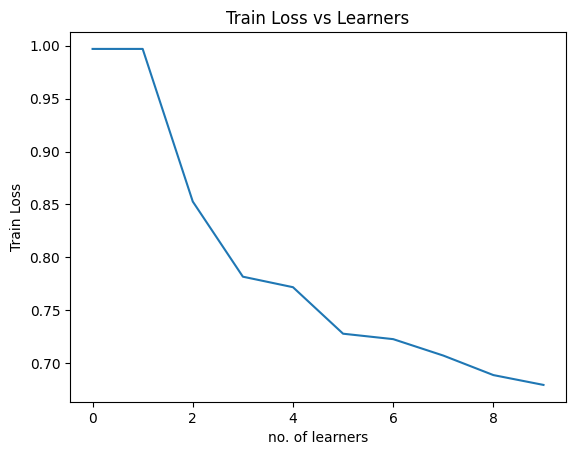

In [1268]:
plt.plot(adaboost_tree.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

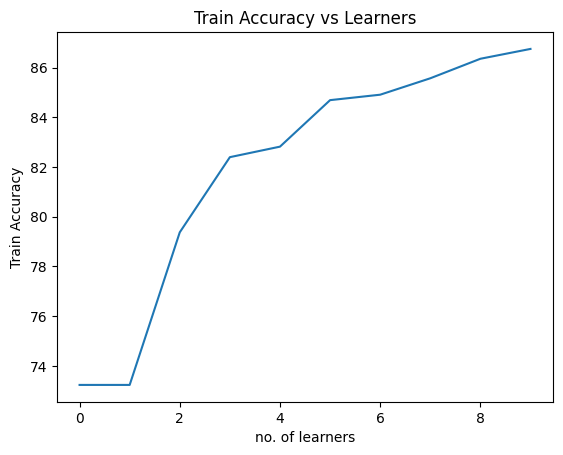

In [1269]:
plt.plot(adaboost_tree.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1270]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost_tree.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 89.15833333333333


In [1271]:
decision_tree = DecisionTreeClassifier(min_samples_split=2, maximum_depth=4)

In [1272]:
y_train = Data_Train[:, 0].astype(int)
X_train = np.delete(Data_Train, 0, axis = 1)
decision_tree.fit(X_train, y_train)

y_test = Data_Test[:, 0].astype(int)
X_test = np.delete(Data_Test, 0, axis = 1)
y_pred = decision_tree.predict(X_test)
print('Accuracy of single Decision Tree on Test Data =', np.mean(y_test == y_pred) * 100)

Accuracy of single Decision Tree on Test Data = 82.68333333333334


### *Assigment-1 p3 Data*

In [1273]:
with open('./Data/p3_train.csv', 'r') as f:
    results = []
#     next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1274]:
Data_Train = np.array(results)
Data_Train[:, [0, -1]] = Data_Train[:, [-1, 0]]
Data_Train[:, 0] = (Data_Train[:, 0] - np.ones(Data_Train[:, 0].shape)).astype(int)

In [1275]:
with open('./Data/p3_test.csv', 'r') as f:
    results = []
#     next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1276]:
Data_Test = np.array(results)
Data_Test[:, [0, -1]] = Data_Test[:, [-1, 0]]
Data_Test[:, 0] = (Data_Test[:, 0] - np.ones(Data_Test[:, 0].shape)).astype(int)

In [1277]:
print(Data_Train.shape)
print(Data_Test.shape)

(60000, 11)
(15000, 11)


In [1278]:
adaboost_tree = AdaboostDecisionTree(6)

In [1279]:
adaboost_tree.train(Data_Train, max_depth = 3)

No. of learners = 1
Accuracy of current Classifier on Train Data = 47.07833333333333
alpha = 1.2692944093190694
Accuracy of Ensemble on Train Data = 47.07833333333333
Train Loss of Ensemble = 1.6117515578971633


No. of learners = 2
Accuracy of current Classifier on Train Data = 46.916666666666664
alpha = 1.0038683655075644
Accuracy of Ensemble on Train Data = 47.07833333333333
Train Loss of Ensemble = 1.6117515578971633


No. of learners = 3
Accuracy of current Classifier on Train Data = 43.141666666666666
alpha = 0.6840631354820267
Accuracy of Ensemble on Train Data = 51.126666666666665
Train Loss of Ensemble = 1.5165994345851368


No. of learners = 4
Accuracy of current Classifier on Train Data = 37.583333333333336
alpha = 0.6106715870471554
Accuracy of Ensemble on Train Data = 53.535
Train Loss of Ensemble = 1.4599939104246271


No. of learners = 5
Accuracy of current Classifier on Train Data = 33.934999999999995
alpha = 0.4674493626817715
Accuracy of Ensemble on Train Data = 54.46

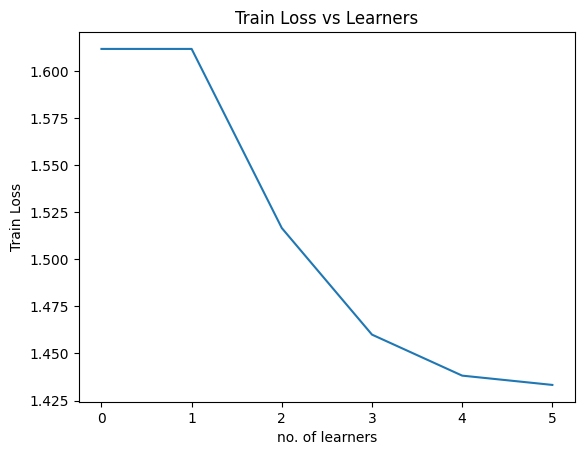

In [1280]:
plt.plot(adaboost_tree.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

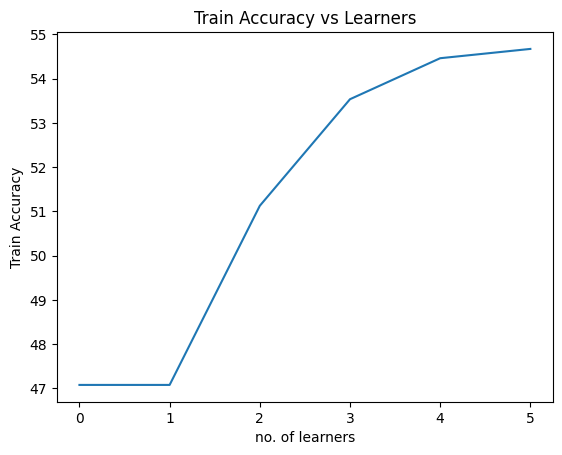

In [1281]:
plt.plot(adaboost_tree.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1282]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost_tree.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 54.513333333333335


In [1283]:
decision_tree = DecisionTreeClassifier(min_samples_split=2, maximum_depth=3)

In [1284]:
y_train = Data_Train[:, 0].astype(int)
X_train = np.delete(Data_Train, 0, axis = 1)
decision_tree.fit(X_train, y_train)

y_test = Data_Test[:, 0].astype(int)
X_test = np.delete(Data_Test, 0, axis = 1)
y_pred = decision_tree.predict(X_test)
print('Accuracy of single Decision Tree on Test Data =', np.mean(y_test == y_pred) * 100)

Accuracy of single Decision Tree on Test Data = 49.559999999999995


## Ensemble of MLPs

### *Fully Connected Layer*

In [1285]:
class Layer_FullyConnected:
    # Layer Initialization
    def __init__(self, n_inputs, n_neurons):
        
        #Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))   

    def forward(self, inputs):
        
        # calculate the values of the neurons before activation
        # inputs matrix contains features for a sample of data
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights) + self.biases
        return self.output
    
    def backward(self, dvalues):
        
        # dvalues are the upstream gradients
        # dweights, dbiases are the backprop gradients with shape similar to weights matrix and bias vector
        # dinputs are the dvalues for the previous layer with shape similar to inputs
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs = np.dot(dvalues, self.weights.T)
        return self.dinputs

### *Input Layer*

In [1286]:
class Layer_Input:
    def __init__(self, input_size):
        self.input_size = input_size      
    # Forward pass
    def forward(self, x):
        assert len(x.shape) == 2 and x.shape[1] == self.input_size, f"Input size mismatch: expected ({x.shape[0]}, {self.input_size}), got {x.shape}"
        self.output = x
        return self.output

### *Activations (Softmax, Sigmoid)*

In [1287]:
class Activation_Sigmoid:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output
        return self.dinputs

In [1288]:
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
        probabilities = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
        self.output = probabilities
        return self.output
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
        return self.dinputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis = 1)

### *SGD Optimizer*

In [1289]:
class Optimizer_SGD:
    
    def __init__(self, learning_rate = 1, decay = 0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)
            
    def update_params(self, layer):
        if isinstance(layer, Layer_FullyConnected):
            layer.weights += -self.current_learning_rate * layer.dweights
            layer.biases += -self.current_learning_rate * layer.dbiases  
            
    def post_update_params(self):
        self.iterations += 1

### *Cross Entropy Loss with Softmax Activation*

In [1290]:
class Softmax_CrossEntropyLoss:

    def forward(self, y_pred, y_true, classes):
        
        # y_pred shape: (batch_size, num_classes)
        # y_true shape: (batch_size,)
        batch_size = y_pred.shape[0]
        # Clip y_pred values to prevent log(0) errors
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the log of predicted probabilities for the true class for each example
        log_likelihoods = -np.log(y_pred[range(batch_size), y_true])
        # Compute the mean of the log likelihoods for the batch
        loss = np.mean(log_likelihoods)
        return loss
    
    def backward(self, dvalues, y_true, classes):
        
          # Number of samples
        samples = len(dvalues)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        return self.dinputs

### *Neural Network Class*

In [1291]:
class NeuralNet:
    
    def __init__(self, input_size, hidden_sizes, output_size, loss, optimizer, activation = 'relu'):
        
        # Layers
        self.input_layer = Layer_Input(input_size)
        self.hidden_layers = []
        self.loss_fn = loss
        self.train_loss = []
        self.optimizer = optimizer
        for i, hidden_size in enumerate(hidden_sizes):
            fc_layer = Layer_FullyConnected(input_size if i == 0 else hidden_sizes[i-1], hidden_size)
            if activation == 'relu':
                activation_layer = Activation_ReLU()
            elif activation == 'sigmoid':
                activation_layer = Activation_Sigmoid()
            elif activation == 'linear':
                activation_layer = Activation_Linear()
            self.hidden_layers.extend([fc_layer, activation_layer])
        self.output_layer = Layer_FullyConnected(hidden_sizes[-1], output_size)
        self.output_softmax_layer = Activation_Softmax()

    def forward(self, x):
        
        x = self.input_layer.forward(x)
        for layer in self.hidden_layers:
            x = layer.forward(x)
        x = self.output_layer.forward(x)
        x = self.output_softmax_layer.forward(x)
        return x

    def backward(self, y_pred, y_true, classes):
        
         # Compute the derivative of the loss with respect to the output of the model

        dL_dy = self.loss_fn.backward(y_pred, y_true, classes)
        
        if isinstance(self.loss_fn, MeanSquareLoss):
             dL_dy = self.output_softmax_layer.backward(dL_dy)
        
         # backpropagate the derivatives through the output layer
        dL_dx = self.output_layer.backward(dL_dy)
        
        for layer in reversed(self.hidden_layers):
            dL_dx = layer.backward(dL_dx)
    
    def train(self, X, classes, epochs = 2, batch_size = 32, val_data = None):
        
        for epoch in range(epochs):
            
            np.random.shuffle(X)
            epoch_accuracy = 0
            for i in range(0, X.shape[0], batch_size):
                batch = X[i:min(X.shape[0], i + batch_size), :]
                x_batch, y_batch = preprocess_data(batch)
                # Forward pass
                outputs = self.forward(x_batch)
        
                predictions = self.output_softmax_layer.predictions(outputs)

                # Accuracy
                epoch_accuracy += np.count_nonzero(predictions == y_batch)
                
                self.backward(outputs, y_batch, classes)
                  
                for layer in self.hidden_layers:
                    self.optimizer.pre_update_params()
                    self.optimizer.update_params(layer)
                    self.optimizer.post_update_params()
                self.optimizer.update_params(self.output_layer)
#             self.calculate_loss(X)
            print('Epoch: ', epoch + 1, ' Accuracy: ', round(epoch_accuracy * 100 / len(X), 2))
    
    def test(self, X):
        
#         test_accuracy = 0
        x, y = preprocess_data(X)
        # Forward pass
        outputs = self.forward(x)
        predictions = self.output_softmax_layer.predictions(outputs)
        return predictions
    
    def calculate_loss(self, X):
        
        train_data, train_labels = preprocess_data(X)
        classes = np.unique(X[:, 0].astype(int))
        outputs = self.forward(train_data)
        self.train_loss.append(self.loss_fn.forward(outputs, train_labels, classes))


In [1292]:
def configuration(input_features, hidden_sizes, output_classes, learning_rate, loss_fn = 'softmax_ce_loss', activation = 'sigmoid'):
    
    if loss_fn == 'softmax_ce_loss':
        loss_fn = Softmax_CrossEntropyLoss()
    else:
        loss_fn = MeanSquareLoss()
    optimizer = Optimizer_SGD(learning_rate, decay = 0)
    model = NeuralNet(input_features, hidden_sizes, output_classes, loss_fn, optimizer)
    return model

In [1293]:
class AdaboostNeuralNet:
    
    def __init__(self, n_estimators, architectures):
        self.n_estimators = n_estimators
        self.estimators = []
        self.learners = len(architectures)
        self.estimator_weights = []
        self.loss_list = []
        self.classes = None
        self.acc_list = []
        
    def train(self, X):
        n_samples, _ = X.shape
        y_train = X[:, 0].astype(int)
#         X_train = np.delete(X, 0, axis = 1)
        self.classes = np.unique(X[:, 0].astype(int))
        weights = np.ones(n_samples) / n_samples
        input_features = X.shape[1] - 1
        output_classes = len(self.classes)
        weights = np.ones(n_samples) / n_samples
        for i in range(self.n_estimators):
            for j in range(self.learners):
                estimator = configuration(input_features, architectures[j], output_classes, 0.01)
            
                Sampled_X = SampleData(X, weights)
                estimator.train(Sampled_X, self.classes)
                y_pred = estimator.test(X)
                err = np.sum(weights * (y_pred != y_train))

                alpha = np.log((1-err)/err) + np.log(len(self.classes) - 1)
                weights *= np.exp(alpha * (y_pred != y_train))
                weights /= np.sum(weights)
                self.estimators.append(estimator)
                self.estimator_weights.append(alpha)
                print('No. of learners =', len(self.estimators))
                print('Accuracy of current Classifier on Train Data =', self.accuracy(y_pred, y_train))
                print('alpha =', alpha)
                y_pred_tillnow, acc = self.test(X)
                print('Accuracy of Ensemble on Train Data =', acc )
                self.update_loss(y_train, y_pred_tillnow)
                self.update_acc(acc)
                print('\n')
            
    def test(self, X):
        y_true = X[:, 0].astype(int)
        y_allclasses = []
        for i in range(len(self.classes)):
            y_pred_current = np.zeros(len(X))
            for estimator, alpha in zip(self.estimators, self.estimator_weights):
                current_predictions = estimator.test(X)
                indicators = [1 if x == self.classes[i] else 0 for x in current_predictions]
                y_pred_current += alpha * np.array(indicators).reshape(current_predictions.shape)
            y_allclasses.append(y_pred_current)
        y_allclasses = np.array(y_allclasses)

        y_pred = np.argmax(y_allclasses, axis = 0)

        acc = self.accuracy(y_true, y_pred)
        return y_pred, acc


    def update_loss(self, y_true, y_pred):
        matches = Match_List(y_true, y_pred)
        loss = np.mean(np.exp(-matches))
        print('Train Loss of Ensemble =', loss)
        self.loss_list.append(loss)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred) * 100
    
    def update_acc(self, acc):
        self.acc_list.append(acc)
    

### *PCA_MNIST Data*

In [1294]:
with open('./Data/PCA_MNIST.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1295]:
Data = np.array(results)

In [1296]:
print(Data.shape)

(60000, 11)


In [1297]:
Data_Train, Data_Test = DataSplit(Data, 80, 20, val_percent = 0)

In [1298]:
print(Data_Train.shape)
print(Data_Test.shape)

(48000, 11)
(12000, 11)


In [1299]:
architectures = [[16], [20], [30]]
adaboost_neural = AdaboostNeuralNet(10, architectures)

In [1300]:
adaboost_neural.train(Data_Train)

Epoch:  1  Accuracy:  42.59
Epoch:  2  Accuracy:  43.51
No. of learners = 1
Accuracy of current Classifier on Train Data = 30.052083333333336
alpha = 1.3524056473210804
Accuracy of Ensemble on Train Data = 30.052083333333336
Train Loss of Ensemble = 2.011936944362718


Epoch:  1  Accuracy:  48.46
Epoch:  2  Accuracy:  45.6
No. of learners = 2
Accuracy of current Classifier on Train Data = 38.6625
alpha = 1.8745060457329106
Accuracy of Ensemble on Train Data = 38.6625
Train Loss of Ensemble = 1.8095575054739754


Epoch:  1  Accuracy:  53.35
Epoch:  2  Accuracy:  53.14
No. of learners = 3
Accuracy of current Classifier on Train Data = 62.635416666666664
alpha = 2.8758150103228477
Accuracy of Ensemble on Train Data = 62.854166666666664
Train Loss of Ensemble = 1.2409559946159832


Epoch:  1  Accuracy:  47.95
Epoch:  2  Accuracy:  47.49
No. of learners = 4
Accuracy of current Classifier on Train Data = 49.262499999999996
alpha = 2.536216297157062
Accuracy of Ensemble on Train Data = 70.889

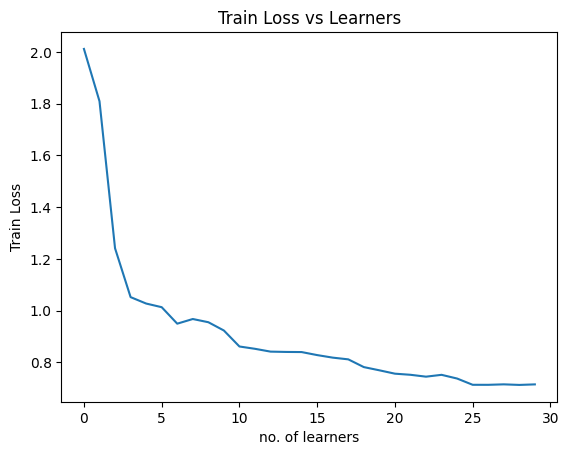

In [1301]:
plt.plot(adaboost_neural.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

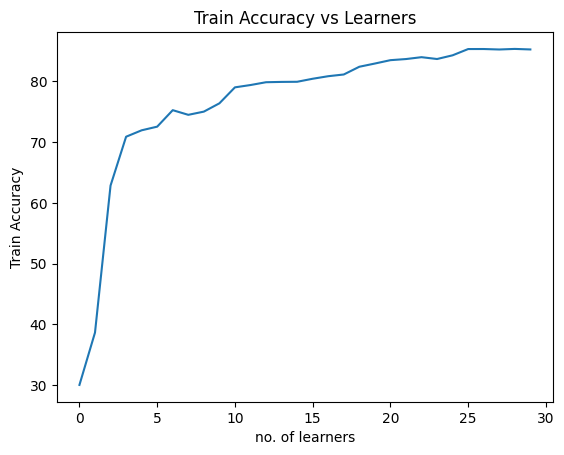

In [1302]:
plt.plot(adaboost_neural.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1303]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost_neural.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 88.25


In [1304]:
input_features = Data_Train.shape[1] - 1
classes = np.unique(Data_Train[:, 0].astype(int))
output_classes = len(classes)

for i in range(len(architectures)):
    model = configuration(input_features, architectures[i], output_classes, 0.01)
    model.train(Data_Train, classes)
    y_test = model.test(Data_Test)
    y_true = Data_Test[:, 0].astype(int)
    print('Accuracy of only 1 MLP with', architectures[i], 'neurons on Test Data =', np.mean(y_test == y_true) * 100)

Epoch:  1  Accuracy:  42.61
Epoch:  2  Accuracy:  41.38
Accuracy of only 1 MLP with [16] neurons on Test Data = 35.36666666666667
Epoch:  1  Accuracy:  44.14
Epoch:  2  Accuracy:  43.89
Accuracy of only 1 MLP with [20] neurons on Test Data = 56.266666666666666
Epoch:  1  Accuracy:  46.19
Epoch:  2  Accuracy:  47.47
Accuracy of only 1 MLP with [30] neurons on Test Data = 40.541666666666664


### *Assignment - 1 p3 Data*

In [1305]:
with open('./Data/p4.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1306]:
Data = np.array(results)

In [1307]:
print(Data.shape)

(60000, 785)


In [1308]:
Data_Train, Data_Test = DataSplit(Data, 80, 20, val_percent = 0)

In [1309]:
print(Data_Train.shape)
print(Data_Test.shape)

(48000, 785)
(12000, 785)


In [1310]:
architectures = [[16], [20], [30]]
adaboost_neural = AdaboostNeuralNet(5, architectures)

In [1311]:
adaboost_neural.train(Data_Train)

Epoch:  1  Accuracy:  43.02
Epoch:  2  Accuracy:  43.49
No. of learners = 1
Accuracy of current Classifier on Train Data = 43.333333333333336
alpha = 1.9289605907415404
Accuracy of Ensemble on Train Data = 43.333333333333336
Train Loss of Ensemble = 1.6997741273010836


Epoch:  1  Accuracy:  18.45
Epoch:  2  Accuracy:  19.12
No. of learners = 2
Accuracy of current Classifier on Train Data = 19.90625
alpha = 0.7324368221856703
Accuracy of Ensemble on Train Data = 43.333333333333336
Train Loss of Ensemble = 1.6997741273010836


Epoch:  1  Accuracy:  42.39
Epoch:  2  Accuracy:  44.85
No. of learners = 3
Accuracy of current Classifier on Train Data = 29.170833333333334
alpha = 1.6997160022512203
Accuracy of Ensemble on Train Data = 43.31041666666667
Train Loss of Ensemble = 1.700312761181504


Epoch:  1  Accuracy:  31.31
Epoch:  2  Accuracy:  35.12
No. of learners = 4
Accuracy of current Classifier on Train Data = 17.522916666666667
alpha = 1.522635905877479
Accuracy of Ensemble on Train D

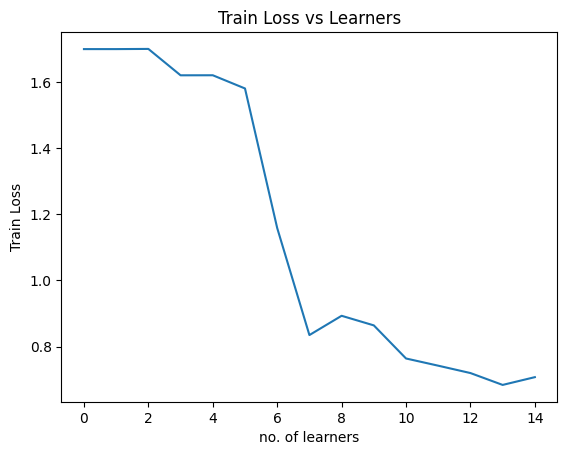

In [1312]:
plt.plot(adaboost_neural.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

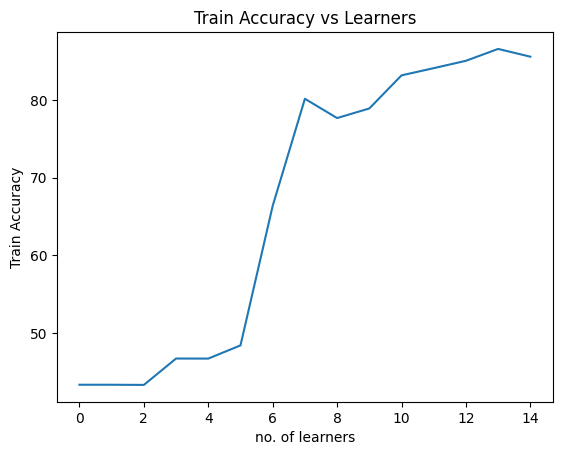

In [1313]:
plt.plot(adaboost_neural.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1314]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost_neural.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 88.34166666666667


In [1315]:
input_features = Data_Train.shape[1] - 1
classes = np.unique(Data_Train[:, 0].astype(int))
output_classes = len(classes)

for i in range(len(architectures)):
    model = configuration(input_features, architectures[i], output_classes, 0.01)
    model.train(Data_Train, classes)
    y_test = model.test(Data_Test)
    y_true = Data_Test[:, 0].astype(int)
    print('Accuracy of only 1 MLP with', architectures[i], 'neurons on Test Data =', np.mean(y_test == y_true) * 100)

Epoch:  1  Accuracy:  36.49
Epoch:  2  Accuracy:  37.03
Accuracy of only 1 MLP with [16] neurons on Test Data = 31.225
Epoch:  1  Accuracy:  38.56
Epoch:  2  Accuracy:  44.21
Accuracy of only 1 MLP with [20] neurons on Test Data = 46.90833333333334
Epoch:  1  Accuracy:  43.57
Epoch:  2  Accuracy:  54.55
Accuracy of only 1 MLP with [30] neurons on Test Data = 56.041666666666664


## Ensemble of MLPs and Decision Trees

In [1316]:
class Adaboost:
    
    def __init__(self, n_estimators, classifiers):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []
        self.loss_list = []
        self.classes = None
        self.acc_list = []
        self.classifiers = classifiers
        
    def train(self, X, max_depth = 4, impurity = 'gini'):
        
        n_samples, _ = X.shape
        y_train = X[:, 0].astype(int)
        X_train = np.delete(X, 0, axis = 1)
        self.classes = np.unique(X[:, 0].astype(int))
        weights = np.ones(n_samples) / n_samples
        input_features = X.shape[1] - 1
        output_classes = len(self.classes)
        weights = np.ones(n_samples) / n_samples
        for i in range(self.n_estimators):
            if self.classifiers[i] == 'decision':
                estimator = DecisionTreeClassifier(min_samples_split=2, maximum_depth = max_depth, impurity = impurity)
            else:
                estimator = configuration(input_features, [16], output_classes, 0.01)
            
            Sampled_X = SampleData(X, weights)
            if self.classifiers[i] == 'decision':
                Sampled_ytrain = Sampled_X[:, 0].astype(int)
                Sampled_Xtrain = np.delete(Sampled_X, 0, axis = 1)
                estimator.fit(Sampled_Xtrain, Sampled_ytrain)
                y_pred = estimator.predict(X_train)
            else:
                estimator.train(Sampled_X, self.classes)
                y_pred = estimator.test(X)
            
            err = np.sum(weights * (y_pred != y_train))

            alpha = np.log((1-err)/err) + np.log(len(self.classes) - 1)
            weights *= np.exp(alpha * (y_pred != y_train))
            weights /= np.sum(weights)
            self.estimators.append(estimator)
            self.estimator_weights.append(alpha)
            print('No. of learners =', len(self.estimators))
            if self.classifiers[i] == 'decision':
                print('Current Estimator is Decision Tree')
            else:
                print('Current Estimator is MLP')
            print('Accuracy of current Classifier on Train Data =', self.accuracy(y_pred, y_train))
            print('alpha =', alpha)
            y_pred_tillnow, acc = self.test(X)
            print('Accuracy of Ensemble on Train Data =', acc )
            self.update_loss(y_train, y_pred_tillnow)
            self.update_acc(acc)
            print('\n')
            
    def test(self, X):
     
        y_true = X[:, 0].astype(int)
        X_test = np.delete(X, 0, axis = 1)
        y_allclasses = []
        for i in range(len(self.classes)):
            y_pred_current = np.zeros(len(X))
            for estimator, alpha in zip(self.estimators, self.estimator_weights):
                if isinstance(estimator, DecisionTreeClassifier):
                    current_predictions = estimator.predict(X_test)
                else:
                    current_predictions = estimator.test(X)
                indicators = [1 if x == self.classes[i] else 0 for x in current_predictions]
                y_pred_current += alpha * np.array(indicators).reshape(current_predictions.shape)
            y_allclasses.append(y_pred_current)
        y_allclasses = np.array(y_allclasses)

        y_pred = np.argmax(y_allclasses, axis = 0)

        acc = self.accuracy(y_true, y_pred)
        return y_pred, acc


    def update_loss(self, y_true, y_pred):
        matches = Match_List(y_true, y_pred)
        loss = np.mean(np.exp(-matches))
        print('Train Loss of Ensemble =', loss)
        self.loss_list.append(loss)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred) * 100
    
    def update_acc(self, acc):
        self.acc_list.append(acc)
    

### *PCA_MNIST Data*

In [1317]:
with open('./Data/PCA_MNIST.csv', 'r') as f:
    results = []
    next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1318]:
Data = np.array(results)

In [1319]:
print(Data.shape)

(60000, 11)


In [1320]:
Data_Train, Data_Test = DataSplit(Data, 80, 20, val_percent = 0)

In [1321]:
print(Data_Train.shape)
print(Data_Test.shape)

(48000, 11)
(12000, 11)


In [1322]:
classifiers = ['decision', 'mlp'] * 10
adaboost = Adaboost(20, classifiers)

In [1323]:
adaboost.train(Data_Train)

No. of learners = 1
Current Estimator is Decision Tree
Accuracy of current Classifier on Train Data = 75.73958333333334
alpha = 3.3356794201019353
Accuracy of Ensemble on Train Data = 75.73958333333334
Train Loss of Ensemble = 0.9380968536706954


Epoch:  1  Accuracy:  36.31
Epoch:  2  Accuracy:  34.29
No. of learners = 2
Current Estimator is MLP
Accuracy of current Classifier on Train Data = 42.672916666666666
alpha = 1.9511279783625413
Accuracy of Ensemble on Train Data = 75.73958333333334
Train Loss of Ensemble = 0.9380968536706954


No. of learners = 3
Current Estimator is Decision Tree
Accuracy of current Classifier on Train Data = 57.725
alpha = 2.4991370832987827
Accuracy of Ensemble on Train Data = 79.50833333333334
Train Loss of Ensemble = 0.8495160636997937


Epoch:  1  Accuracy:  42.49
Epoch:  2  Accuracy:  43.12
No. of learners = 4
Current Estimator is MLP
Accuracy of current Classifier on Train Data = 60.202083333333334
alpha = 2.03234669627452
Accuracy of Ensemble on Trai

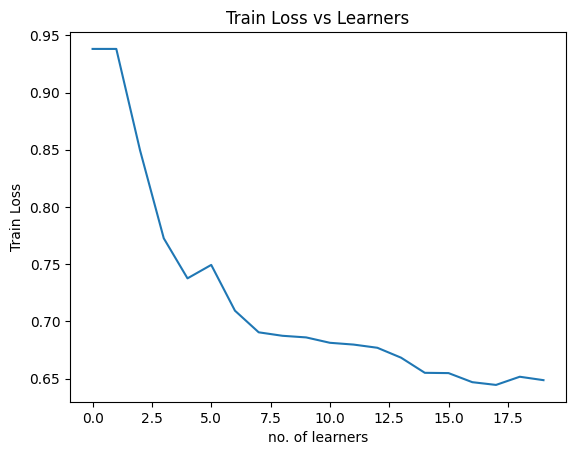

In [1324]:
plt.plot(adaboost.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

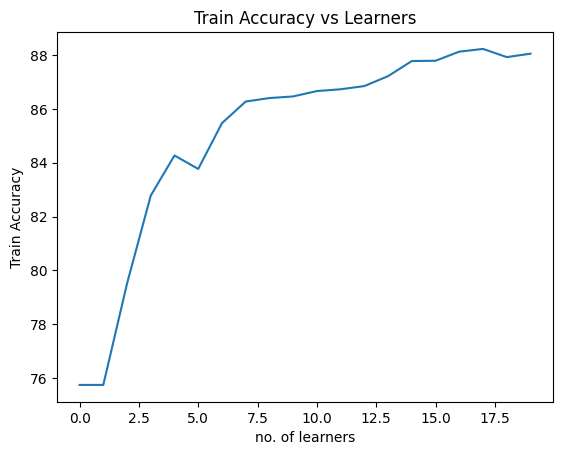

In [1325]:
plt.plot(adaboost.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1326]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 90.50833333333334


In [1327]:
input_features = Data_Train.shape[1] - 1
classes = np.unique(Data_Train[:, 0].astype(int))
output_classes = len(classes)
model = configuration(input_features, [16], output_classes, 0.01)
model.train(Data_Train, classes)
y_test = model.test(Data_Test)
y_true = Data_Test[:, 0].astype(int)
print('Accuracy of only 1 MLP with [16] neurons on Test Data =', np.mean(y_test == y_true) * 100)

Epoch:  1  Accuracy:  41.8
Epoch:  2  Accuracy:  42.14
Accuracy of only 1 MLP with [16] neurons on Test Data = 48.56666666666667


In [1328]:
y_train = Data_Train[:, 0].astype(int)
X_train = np.delete(Data_Train, 0, axis = 1)
decision_tree.fit(X_train, y_train)

y_test = Data_Test[:, 0].astype(int)
X_test = np.delete(Data_Test, 0, axis = 1)
y_pred = decision_tree.predict(X_test)
print('Accuracy of single Decision Tree on Test Data =', np.mean(y_test == y_pred) * 100)

Accuracy of single Decision Tree on Test Data = 70.36666666666666


### *Assigment-1 p3 Data*

In [1329]:
with open('./Data/p3_train.csv', 'r') as f:
    results = []
#     next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1330]:
Data_Train = np.array(results)
Data_Train[:, [0, -1]] = Data_Train[:, [-1, 0]]
Data_Train[:, 0] = (Data_Train[:, 0] - np.ones(Data_Train[:, 0].shape)).astype(int)

In [1331]:
with open('./Data/p3_test.csv', 'r') as f:
    results = []
#     next(f)
    for line in f:
        words = line.split(',')
        for i in range(len(words)):
            words[i] = float(words[i])
        results.append(words)

In [1332]:
Data_Test = np.array(results)
Data_Test[:, [0, -1]] = Data_Test[:, [-1, 0]]
Data_Test[:, 0] = (Data_Test[:, 0] - np.ones(Data_Test[:, 0].shape)).astype(int)

In [1333]:
print(Data_Train.shape)
print(Data_Test.shape)

(60000, 11)
(15000, 11)


In [1336]:
classifiers = ['decision', 'mlp'] * 5
adaboost = Adaboost(10, classifiers)

In [1337]:
adaboost.train(Data_Train, max_depth = 3)

No. of learners = 1
Current Estimator is Decision Tree
Accuracy of current Classifier on Train Data = 47.73833333333333
alpha = 1.2957659186890558
Accuracy of Ensemble on Train Data = 47.73833333333333
Train Loss of Ensemble = 1.5962389021410652


Epoch:  1  Accuracy:  27.95
Epoch:  2  Accuracy:  39.58
No. of learners = 2
Current Estimator is MLP
Accuracy of current Classifier on Train Data = 49.67166666666667
alpha = 1.0805038748505207
Accuracy of Ensemble on Train Data = 47.73833333333333
Train Loss of Ensemble = 1.5962389021410652


No. of learners = 3
Current Estimator is Decision Tree
Accuracy of current Classifier on Train Data = 29.349999999999998
alpha = 0.5160923290271061
Accuracy of Ensemble on Train Data = 48.85333333333333
Train Loss of Ensemble = 1.5700319155228084


Epoch:  1  Accuracy:  24.2
Epoch:  2  Accuracy:  26.04
No. of learners = 4
Current Estimator is MLP
Accuracy of current Classifier on Train Data = 34.165
alpha = 0.46903913619011406
Accuracy of Ensemble on Tra

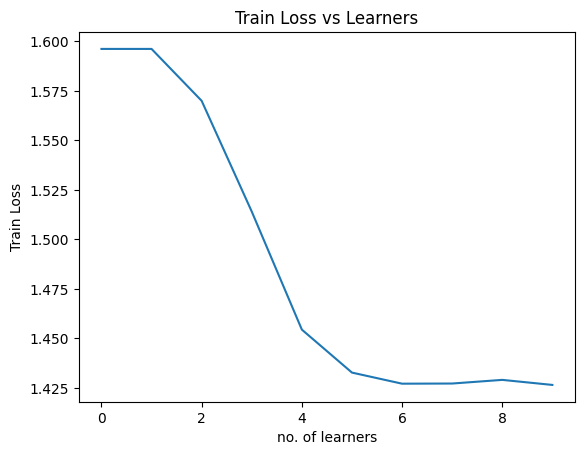

In [1338]:
plt.plot(adaboost.loss_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Learners')
plt.show()

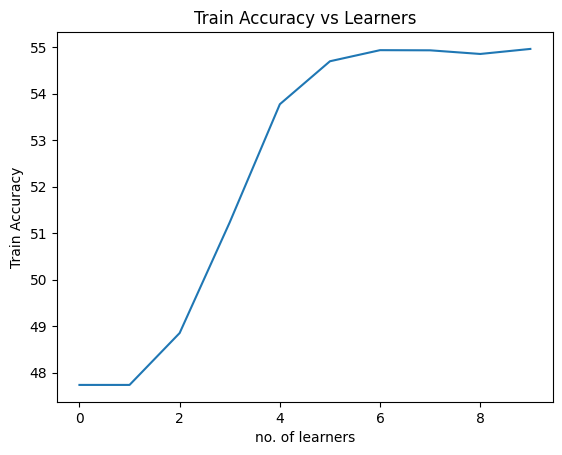

In [1339]:
plt.plot(adaboost.acc_list)
plt.xlabel('no. of learners')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy vs Learners')
plt.show()

In [1340]:
print('Accuracy of Ensemble Classifier on Test Data =', adaboost.test(Data_Test)[1])

Accuracy of Ensemble Classifier on Test Data = 55.22


In [1343]:
input_features = Data_Train.shape[1] - 1
classes = np.unique(Data_Train[:, 0].astype(int))
output_classes = len(classes)
model = configuration(input_features, [16], output_classes, 0.001)
model.train(Data_Train, classes)
y_test = model.test(Data_Test)
y_true = Data_Test[:, 0].astype(int)
print('Accuracy of only 1 MLP with [16] neurons on Test Data =', np.mean(y_test == y_true) * 100)

Epoch:  1  Accuracy:  28.65
Epoch:  2  Accuracy:  38.05
Accuracy of only 1 MLP with [16] neurons on Test Data = 43.62666666666667


In [1342]:
decision_tree = DecisionTreeClassifier(min_samples_split=2, maximum_depth=3)
y_train = Data_Train[:, 0].astype(int)
X_train = np.delete(Data_Train, 0, axis = 1)
decision_tree.fit(X_train, y_train)

y_test = Data_Test[:, 0].astype(int)
X_test = np.delete(Data_Test, 0, axis = 1)
y_pred = decision_tree.predict(X_test)
print('Accuracy of single Decision Tree on Test Data =', np.mean(y_test == y_pred) * 100)

Accuracy of single Decision Tree on Test Data = 49.946666666666665
